Credit Card Fraud Detection

Author: James Fothergill

In [50]:
# Import dataset from Kaggle using API key

!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d uciml/default-of-credit-card-clients-dataset
!unzip -o default-of-credit-card-clients-dataset.zip

# Import necessary libraries

!pip install catboost
!pip install imbalanced-learn


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE

# ML libraries

from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# ML models

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Set display options for crisp visualisations

pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8-whitegrid')

# Set random seed for reproducibility

RANDOM_STATE = 42

Dataset URL: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset
License(s): CC0-1.0
default-of-credit-card-clients-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  default-of-credit-card-clients-dataset.zip
  inflating: UCI_Credit_Card.csv     


In [51]:
# Load dataset and rename target column

df = pd.read_csv('UCI_Credit_Card.csv')
df = df.rename(columns={'default.payment.next.month': 'DEFAULT'})

# Basic info

print("Dataset shape:", df.shape)
print("Column names:", df.columns.tolist())
print("\nClass distribution:")
print(df['DEFAULT'].value_counts(normalize=True).mul(100).round(2))

# Display first few rows

df.head()

Dataset shape: (30000, 25)
Column names: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT']

Class distribution:
DEFAULT
0    77.88
1    22.12
Name: proportion, dtype: float64


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


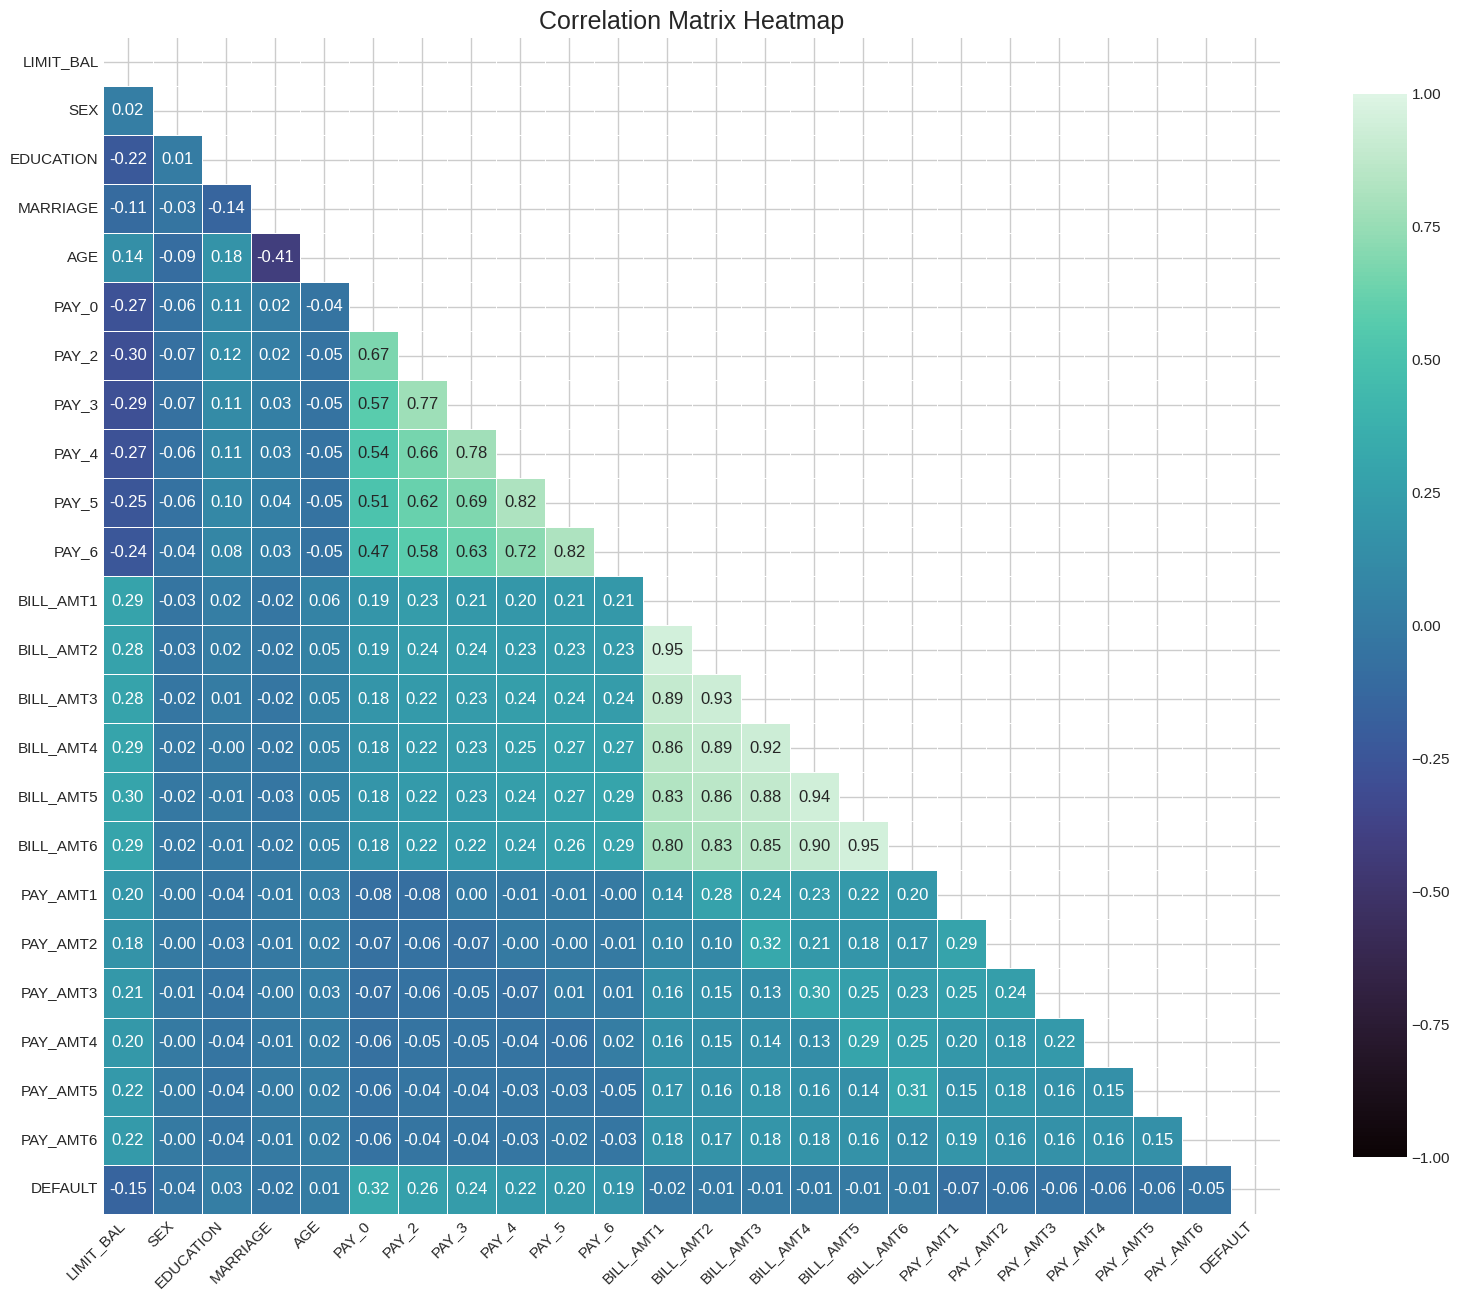

Top features correlated with DEFAULT:
DEFAULT      1.000000
PAY_0        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
EDUCATION    0.028006
AGE          0.013890
BILL_AMT6   -0.005372
Name: DEFAULT, dtype: float64


In [52]:
# Create correlation heatmap

plt.figure(figsize=(16, 14))
corr = df.drop('ID', axis=1).corr()

# Generate mask for upper triangle

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Create heatmap

sns.heatmap(corr, mask=mask, cmap='mako', annot=True, fmt='.2f',
            linewidths=0.5, vmax=1.0, vmin=-1.0, center=0,
            square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show top correlations with DEFAULT

default_corr = corr['DEFAULT'].sort_values(ascending=False)
print("Top features correlated with DEFAULT:")
print(default_corr.head(10))

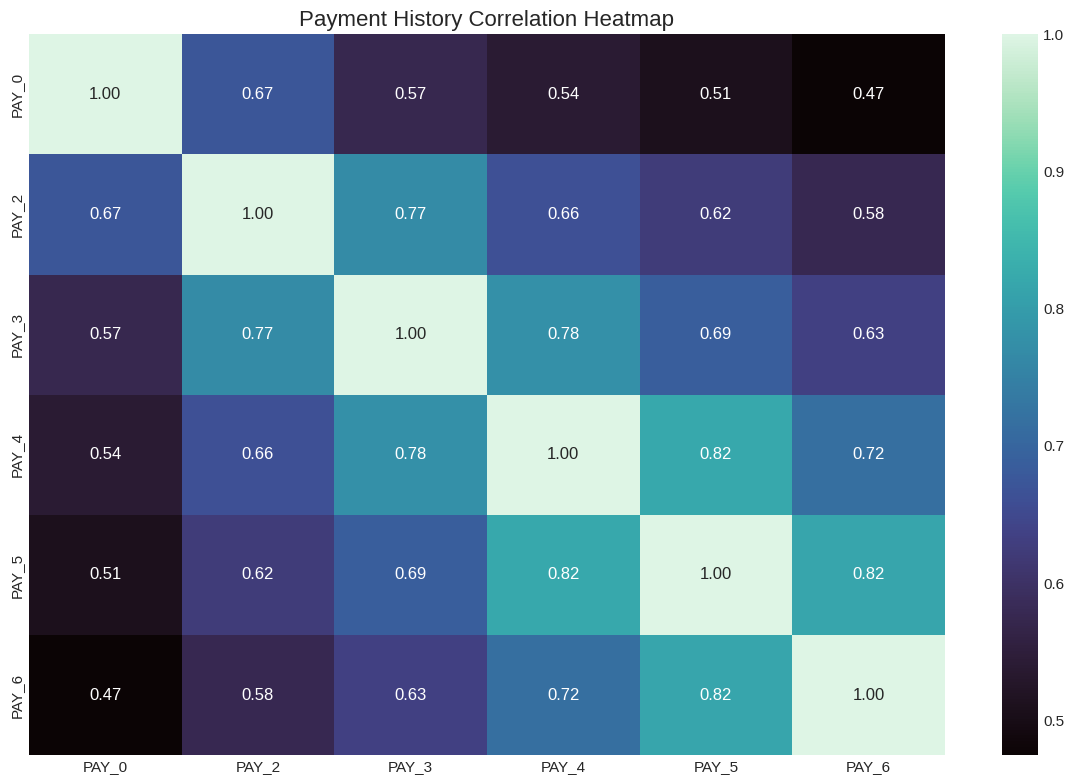

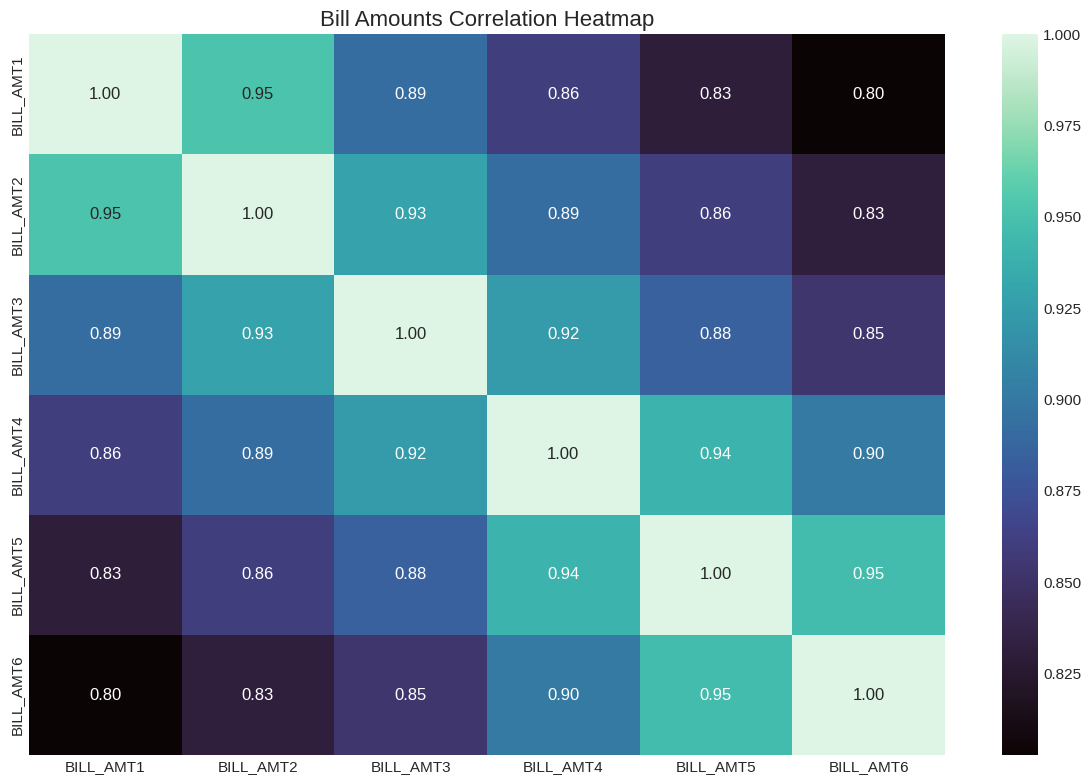

In [53]:
# Additional heatmap for payment history variables

pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Create payment history heatmap

plt.figure(figsize=(12, 8))
pay_corr = df[pay_cols].corr()
sns.heatmap(pay_corr, annot=True, cmap='mako', fmt='.2f')
plt.title('Payment History Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

# Create bill amounts heatmap

plt.figure(figsize=(12, 8))
bill_corr = df[bill_cols].corr()
sns.heatmap(bill_corr, annot=True, cmap='mako', fmt='.2f')
plt.title('Bill Amounts Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

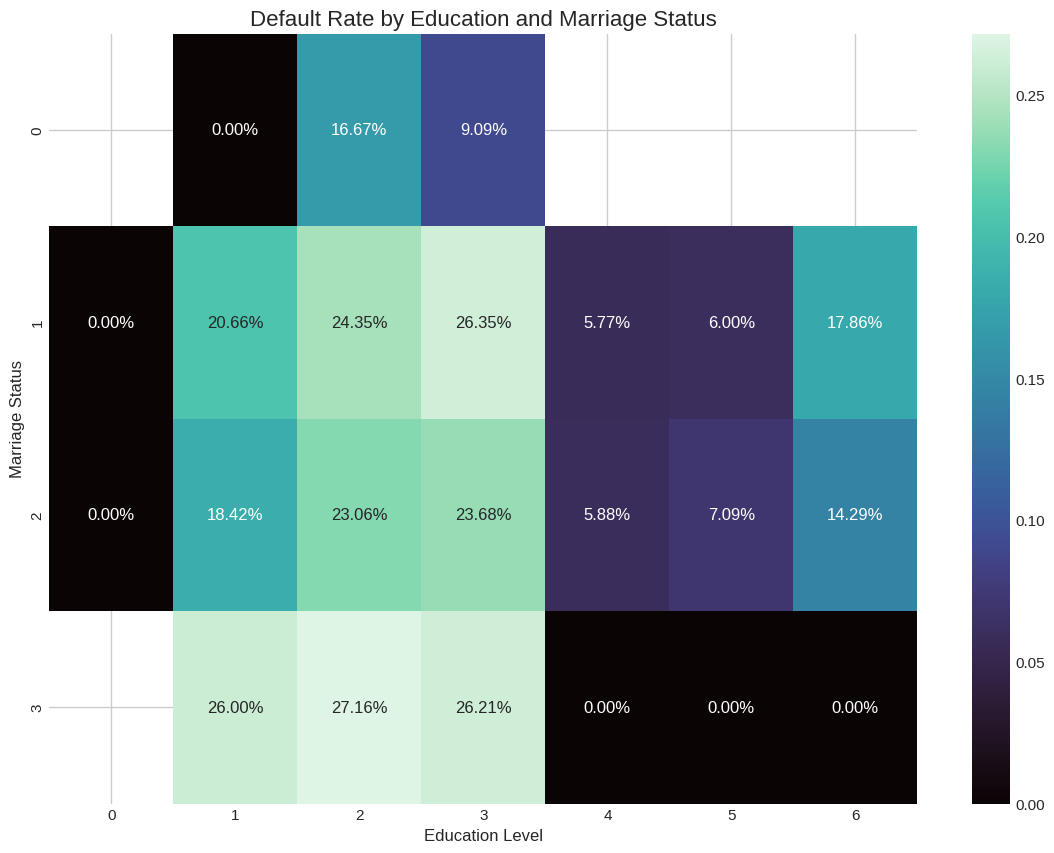

Education levels: 1=graduate school, 2=university, 3=high school, 4=others
Marriage status: 1=married, 2=single, 3=others


In [54]:
# Create heatmap for default rate by demographic features
plt.figure(figsize=(14, 10))

# Create cross-tabulation of EDUCATION and MARRIAGE vs DEFAULT
default_by_edu_mar = pd.crosstab(
    [df['EDUCATION'], df['MARRIAGE']],
    df['DEFAULT'],
    normalize='index'
)

# Plot heatmap showing default rate by education and marriage
sns.heatmap(default_by_edu_mar[1].unstack(level=0), annot=True, cmap='mako', fmt='.2%')
plt.title('Default Rate by Education and Marriage Status', fontsize=16)
plt.ylabel('Marriage Status')
plt.xlabel('Education Level')
plt.show()

print("Education levels: 1=graduate school, 2=university, 3=high school, 4=others")
print("Marriage status: 1=married, 2=single, 3=others")

In [55]:
# Feature engineering function
def engineer_features(df):
    df = df.copy()

    # Handle zeros in denominators by adding small epsilon

    epsilon = 1e-10

    # Create utilisation ratio (bill amount to credit limit) with clipping

    df['UTILISATION_RATIO'] = (df['BILL_AMT1'] / (df['LIMIT_BAL'] + epsilon)).clip(-100, 100)

    # Create payment to bill ratio with clipping

    df['PAY_TO_BILL_RATIO'] = (df['PAY_AMT1'] / (df['BILL_AMT1'].abs() + 1)).clip(-100, 100)

    # Create history of delay payments feature (count of months with delay)

    df['DELAY_HISTORY'] = (df['PAY_0'] > 0).astype(int) + \
                          (df['PAY_2'] > 0).astype(int) + \
                          (df['PAY_3'] > 0).astype(int) + \
                          (df['PAY_4'] > 0).astype(int) + \
                          (df['PAY_5'] > 0).astype(int) + \
                          (df['PAY_6'] > 0).astype(int)

    # Create max delay indicator

    df['MAX_DELAY'] = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].max(axis=1)

    # Create average bill and payment amounts

    bill_cols = [col for col in df.columns if 'BILL_AMT' in col]
    pay_cols = [col for col in df.columns if 'PAY_AMT' in col]

    df['AVG_BILL'] = df[bill_cols].mean(axis=1)
    df['AVG_PAY'] = df[pay_cols].mean(axis=1)

    # Create bill trend (positive means increasing debt) with clipping

    df['BILL_TREND'] = ((df['BILL_AMT1'] - df['BILL_AMT6']) /
                        (df['BILL_AMT6'].abs() + 1)).clip(-100, 100)

    # Create payment consistency (coefficient of variation of payments) with clipping

    mean_pay = df[pay_cols].mean(axis=1)
    std_pay = df[pay_cols].std(axis=1)
    df['PAY_CONSISTENCY'] = (std_pay / (mean_pay.abs() + 1)).clip(0, 100)

    # Replace any remaining infinities with large but finite values

    df = df.replace([np.inf, -np.inf], [1e6, -1e6])

    # Fill NaN values with column means

    df = df.fillna(df.mean())

    return df

In [56]:
# Preprocess data with informative prints

def preprocess_data(df):
    df = df.copy()

    # Drop ID column

    df = df.drop(['ID'], axis=1)

    # Replace education values 0, 5, 6 with 4 (others) as per dataset description

    df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)

    # Replace marriage value 0 with 3 (others) as per dataset description

    df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)

    # Apply feature engineering

    print("Applying feature engineering...")
    df = engineer_features(df)

    # Define categorical columns for one-hot encoding

    categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']

    # One-hot encode categorical variables

    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Split into features and target

    X = df.drop('DEFAULT', axis=1)
    y = df['DEFAULT']

    # Check for any remaining problematic values before returning

    X = X.replace([np.inf, -np.inf], [1e6, -1e6])
    X = X.fillna(X.mean())

    print("Preprocessing complete (without scaling).")
    return X, y



In [57]:
# Apply preprocessing, split data, apply SMOTE, and scale

try:
    # Preprocess data (without scaling)
    X, y = preprocess_data(df)

    # Check for any issues in the processed data
    print("Any NaN in processed features:", X.isna().sum().sum())
    print("Any infinite values in processed features:", np.isinf(X).sum().sum())

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
    )

    print(f"Original training set shape: {X_train.shape}")
    print(f"Original test set shape: {X_test.shape}")
    print(f"Original class distribution in training set: {np.bincount(y_train)}")
    print(f"Original class distribution in test set: {np.bincount(y_test)}")

    # Apply SMOTE to training data only

    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    print(f"\nAfter SMOTE - training set shape: {X_train_smote.shape}")
    print(f"After SMOTE - class distribution in training set: {np.bincount(y_train_smote)}")

    # Scale both SMOTE-resampled training data and original test data

    print("Scaling features...")
    scaler = StandardScaler()
    X_train_smote_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_smote),
        columns=X_train_smote.columns
    )

    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns
    )

    print("Scaling complete.")
    print(f"Final training set shape: {X_train_smote_scaled.shape}")
    print(f"Final test set shape: {X_test_scaled.shape}")

except Exception as e:
    print(f"Error during preprocessing: {str(e)}")

Applying feature engineering...
Preprocessing complete (without scaling).
Any NaN in processed features: 0
Any infinite values in processed features: 0
Original training set shape: (21000, 34)
Original test set shape: (9000, 34)
Original class distribution in training set: [16355  4645]
Original class distribution in test set: [7009 1991]

After SMOTE - training set shape: (32710, 34)
After SMOTE - class distribution in training set: [16355 16355]
Scaling features...
Scaling complete.
Final training set shape: (32710, 34)
Final test set shape: (9000, 34)


In [58]:
# Define models with hyperparameters

models = {
    'Logistic Regression': LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        random_state=RANDOM_STATE
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),
    'Linear SVM': LinearSVC(
    C=1.0,
    dual=False,
    random_state=RANDOM_STATE
    ),
    'CatBoost': CatBoostClassifier(
     iterations=100,
     depth=6,
     learning_rate=0.1,
     loss_function='Logloss',
     random_seed=RANDOM_STATE,
     verbose=0
    )
}

In [59]:
def evaluate_model(model, X_train, X_test, y_train, y_test):

    # Train model

    model.fit(X_train, y_train)

    # Make predictions

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Cross-validation

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

    # Return results

    results = {
        'accuracy': accuracy,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1': report['1']['f1-score'],
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_prob
    }
    return results

In [61]:
# Evaluate all models

results = {}
for name, model in models.items():
    print(f"Training and evaluating {name}.")
    try:
        results[name] = evaluate_model(model, X_train_smote_scaled, X_test_scaled, y_train_smote, y_test)
        print(f"  Accuracy: {results[name]['accuracy']:.4f}")
        print(f"  Precision: {results[name]['precision']:.4f}")
        print(f"  Recall: {results[name]['recall']:.4f}")
        print(f"  F1 Score: {results[name]['f1']:.4f}")
        print(f"  CV F1: {results[name]['cv_mean']:.4f} (+/-{results[name]['cv_std']:.4f})")
    except Exception as e:
        print(f"  Error evaluating {name}: {str(e)}")
    print()

Training and evaluating Logistic Regression.
  Accuracy: 0.7149
  Precision: 0.3994
  Recall: 0.5736
  F1 Score: 0.4709
  CV F1: 0.7266 (+/-0.0079)

Training and evaluating Random Forest.
  Accuracy: 0.7816
  Precision: 0.5056
  Recall: 0.5665
  F1 Score: 0.5343
  CV F1: 0.7867 (+/-0.0066)

Training and evaluating XGBoost.
  Accuracy: 0.7812
  Precision: 0.5056
  Recall: 0.4982
  F1 Score: 0.5019
  CV F1: 0.8074 (+/-0.0058)

Training and evaluating Linear SVM.
  Accuracy: 0.7267
  Precision: 0.4138
  Recall: 0.5655
  F1 Score: 0.4779
  CV F1: 0.7237 (+/-0.0084)

Training and evaluating CatBoost.
  Accuracy: 0.7799
  Precision: 0.5025
  Recall: 0.5138
  F1 Score: 0.5081
  CV F1: 0.7952 (+/-0.0072)



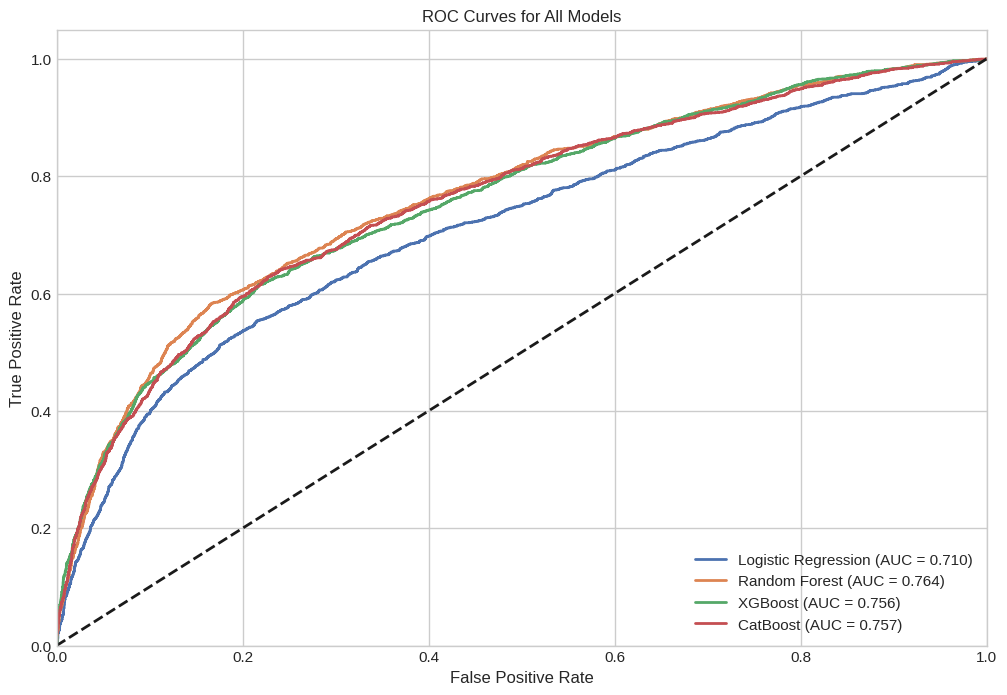

In [62]:
# Plot ROC curves

plt.figure(figsize=(12, 8))

for name, model_results in results.items():
    if model_results['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, model_results['probabilities'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [63]:
# Comparison of models

comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1 Score': [results[m]['f1'] for m in results],
}).sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

print("Model comparison:")
print(comparison)

Model comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.781556   0.505603  0.566549  0.534344
1             CatBoost  0.779889   0.502456  0.513812  0.508071
2              XGBoost  0.781222   0.505607  0.498242  0.501897
3           Linear SVM  0.726667   0.413818  0.565545  0.477929
4  Logistic Regression  0.714889   0.399440  0.573581  0.470928


Best model: Random Forest


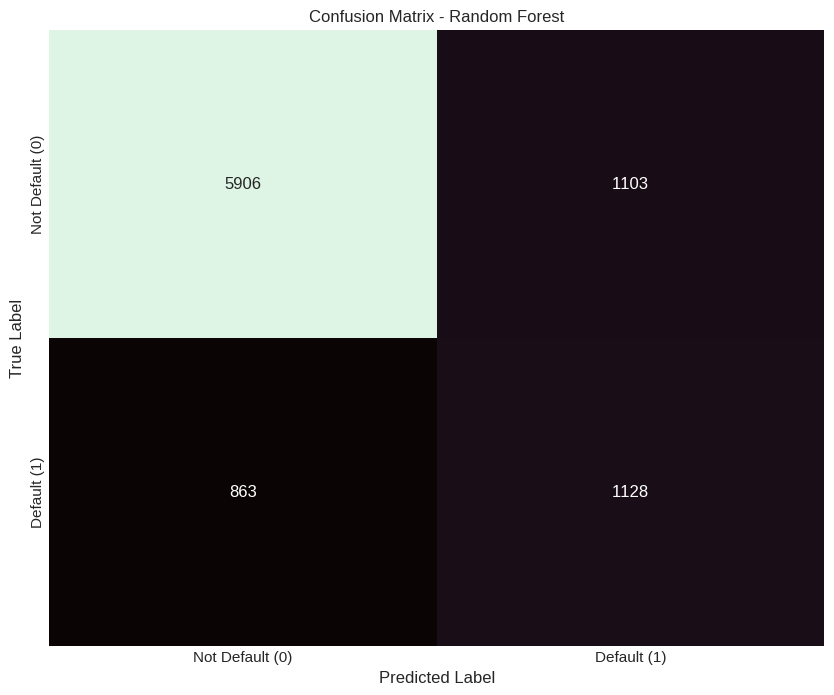

In [64]:
# Get best model based on F1 score

best_model_name = comparison.iloc[0]['Model']
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

# Plot confusion matrix for best model as a heatmap

cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='mako', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Not Default (0)', 'Default (1)'])
plt.yticks([0.5, 1.5], ['Not Default (0)', 'Default (1)'])
plt.show()

Optimal threshold: 0.4867
At this threshold - Precision: 0.4996, Recall: 0.5821


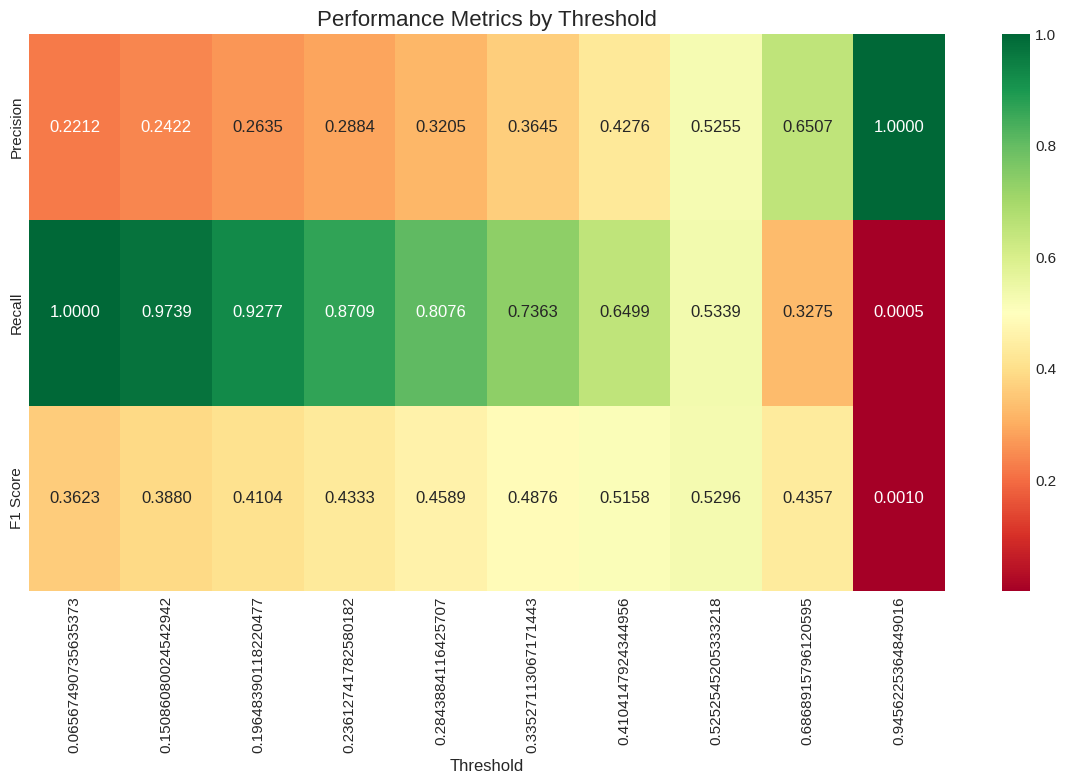

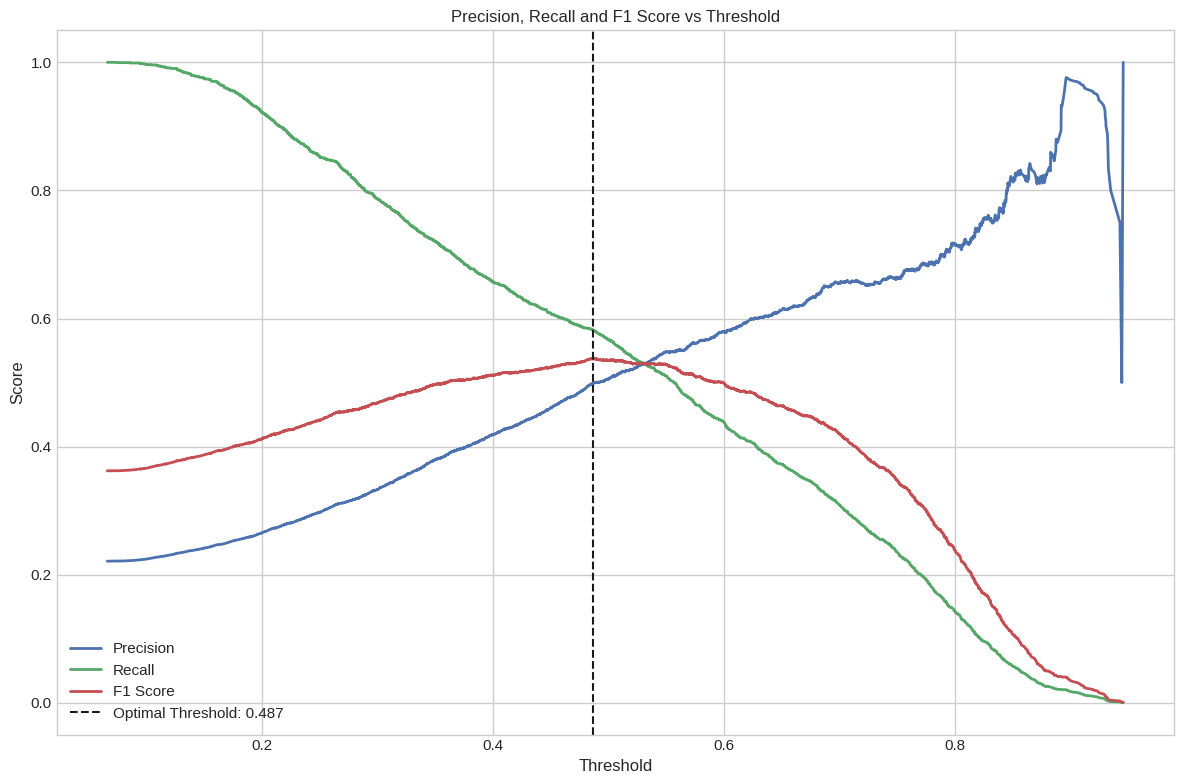

In [65]:
# Threshold optimisation with heatmap-style visualisation

if best_model_name in results:

    # Get the probabilities from the best model

    y_prob = results[best_model_name]['probabilities']

    # Calculate precision and recall for different thresholds

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

    # Calculate F1 score for each threshold

    f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-8)

    # Find the threshold that gives the best F1 score

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"Optimal threshold: {optimal_threshold:.4f}")
    print(f"At this threshold - Precision: {precisions[optimal_idx]:.4f}, Recall: {recalls[optimal_idx]:.4f}")

    # Create a colourful heatmap-style visualisation of threshold performance

    # Sample 10 thresholds for visualisation

    sample_indices = np.linspace(0, len(thresholds)-1, 10, dtype=int)
    threshold_df = pd.DataFrame({
        'Threshold': thresholds[sample_indices],
        'Precision': precisions[sample_indices],
        'Recall': recalls[sample_indices],
        'F1 Score': [2 * (p * r) / (p + r + 1e-8) for p, r in zip(precisions[sample_indices], recalls[sample_indices])]
    })

    # Create heatmap of threshold performance

    plt.figure(figsize=(12, 8))
    threshold_matrix = threshold_df.set_index('Threshold').T
    sns.heatmap(threshold_matrix, annot=True, cmap='RdYlGn', fmt='.4f')
    plt.title('Performance Metrics by Threshold', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Visualise the precision-recall trade-off with thresholds

    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, precisions[:-1], "b-", linewidth=2, label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", linewidth=2, label="Recall")
    plt.plot(thresholds, f1_scores, "r-", linewidth=2, label="F1 Score")
    plt.axvline(x=optimal_threshold, color='k', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.3f}')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision, Recall and F1 Score vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()